# Trump or Troll
## Final Project: Shivam Jindal (sj2546) and Mayank Vanjani (mv1506)

Note: This python notebook is the one we used on Google Colab to run the Neural Networks since it takes a while for those to complete training

Classify tweets sent by President Trump versus Russian trolls

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
import tensorflow.keras.backend as K

# Data Input

In [0]:

df = pd.read_excel("https://github.com/mayankvanjani/trump_or_troll/blob/master/TrumpTwitterAll.xlsx?raw=true")
df2 = pd.read_csv("https://raw.githubusercontent.com/mayankvanjani/trump_or_troll/master/IRAhandle_tweets_1.txt")


trump_tweets_df is a dataframe containing all of the trump tweets from our dataset  
troll_tweets_df is a dataframe containing all of the troll tweets from our dataset

# Data Pre-Processing
## Extracting the Tweets

In [3]:
#df.head(5)
print(df.shape)
print(df2.shape)
print(df.columns)
print(df2.columns)

trump_tweets_df = df["Tweet"]

# We want the same amount of the number of trump tweets
troll_tweets_df = df2["content"][:30078]

(30078, 5)
(243891, 21)
Index(['Date', 'Time', 'Tweet', 'Client', 'Client Simplified'], dtype='object')
Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')


## Examining the tweets

In [4]:
trump_tweets_df.head(5)

0    If the press would cover me accurately & honor...
1    I am thrilled to nominate Dr. @RealBenCarson a...
2    their country (the U.S. doesn't tax them) or t...
3    Did China ask us if it was OK to devalue their...
4    .@FoxNews will be re-running "Objectified: Don...
Name: Tweet, dtype: object

In [5]:
troll_tweets_df.head(5)

0    "We have a sitting Democrat US Senator on tria...
1    Marshawn Lynch arrives to game in anti-Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN: President Trump dedicates Presidents ...
4    19,000 RESPECTING our National Anthem! #StandF...
Name: content, dtype: object

# Preparing the tweets: 

- The vectorizer creates a sparse matrix with the top 5000 features (i.e. different types of words and their TFIDF scores)
- We decided to use a tfidfvectorizer we care about understanding what words matter. Understanding frequency of the words is pretty useful for this


In [6]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, 
                min_df=2,   
                max_features=5000,    
                stop_words='english', 
                use_idf=True )        

# first half are Trump tweets, second half are Troll tweets
all_my_tweeties = trump_tweets_df.append(troll_tweets_df)
all_my_tweeties.head(5)

X = vectorizer.fit_transform(all_my_tweeties)
X.shape

(60156, 5000)

## This displays the terms with the highest TFIDF scores in post 1000 (one of Donald Trump's Posts)

We are doing this to just get an idea of what TFIDF does within a tweet

In [7]:
doc_ind = 1000  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = xi.argsort()[:, ::-1]
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names()

for i in range(10):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

labor                0.428762 
mike_pence           0.412798 
hosting              0.394354 
maga                 0.355841 
leaders              0.342455 
post                 0.329780 
american             0.284062 
thank                0.217162 
https                0.098706 
foxandfriends        0.000000 


# KMeans

- We define a KMeans Class with 2 clusters (one for Trump's tweets and one for Troll's tweets)

In [0]:
km = KMeans(n_clusters=2, init='k-means++', n_init=1, random_state=42)

In [9]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

## This will produce the top 10 largest components in each cluster

In [10]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: http realdonaldtrump thanks trump great president thank https donald just people like don good obama run love america make time
Cluster 1: https enlist di на il la amp army video thank trump patriot mj4n1lcxvf usfa rt join gt trump2016 blacklivesmatter acapa


## Looking at the code above, it makes sense that those are the two clusters. 

- Donald Trump tweets are likely to contain words talking about him 
- Russian Troll tweets may have terms relevant to American politics but also have gibberish that they repeat a lot

This just gives us the labels of Donald Trump tweets and Russian Troll tweets. 

In [0]:
first_half = np.zeros(30078)
second_half = first_half+1

labels = np.append(first_half, second_half)

This gives us a confusion matrix which we can use to understand how well our KMeans algorithm managed to cluster the tweets

In [12]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C, axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.67355768 0.07335441]
 [0.32644232 0.92664559]]


This is quite interesting. It's really good at classifying Trump's tweets as Trump's tweets. 
It has a lot of misclassifications of the Troll tweets, however. 

## Overall Accuracy of KMeans

In [37]:
print("Accuracy of KMeans =", str((C[0,0] + C[1,1])/np.sum(C)))

Accuracy of KMeans = 0.746741804641266


# Word Clouds

Just for fun visualizations, we want to see a word cloud of the common words in Trump's tweets and in Troll's tweets

In [0]:
full_trump_text = " ".join([tweet.lower() for tweet in trump_tweets_df])

We want to not include basic stop words. Also want to get rid of https because this doesn't tell us much....

In [0]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
stopwords.update(["https"])

## Donald Trump Tweet Word Cloud

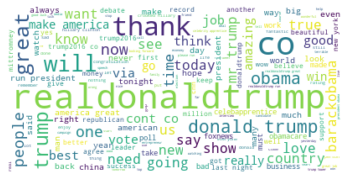

In [15]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(full_trump_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
full_troll_text = " ".join([tweet.lower() for tweet in troll_tweets_df])

## Troll Tweet Word Cloud

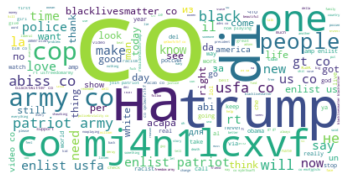

In [17]:

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(full_troll_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Neural Network

Want to use the same X data to 

In [0]:
Xtr, Xts, ytr, yts = train_test_split(X, labels, test_size=0.33, random_state=42)

In [27]:
K.clear_session()
nin = Xtr.shape[1]
print(nin)
nh = 100

nout = 1
model = Sequential()
model.add(Dense(units=500, input_shape=(nin,), activation='relu', name='hidden1'))
model.add(Dense(units=500, input_shape=(500,), activation='relu', name='hidden2'))
model.add(Dense(units=100, input_shape=(500,), activation='relu', name='hidden3'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

5000


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2500500   
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
hidden3 (Dense)              (None, 100)               50100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 2,801,201
Trainable params: 2,801,201
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
             loss='binary_crossentropy', 
             metrics=['accuracy'])
hist = model.fit(Xtr.A, ytr, epochs=10, batch_size=100, validation_data=(Xts.A, yts))

Train on 40304 samples, validate on 19852 samples
Epoch 1/10
40304/40304 [==============================] - 18s 452us/sample - loss: 0.1945 - acc: 0.9248 - val_loss: 0.1435 - val_acc: 0.9437
Epoch 2/10
40304/40304 [==============================] - 18s 449us/sample - loss: 0.0932 - acc: 0.9655 - val_loss: 0.1454 - val_acc: 0.9431
Epoch 3/10
40304/40304 [==============================] - 18s 449us/sample - loss: 0.0468 - acc: 0.9829 - val_loss: 0.1991 - val_acc: 0.9453
Epoch 4/10
40304/40304 [==============================] - 18s 451us/sample - loss: 0.0247 - acc: 0.9910 - val_loss: 0.2295 - val_acc: 0.9452
Epoch 5/10
40304/40304 [==============================] - 18s 451us/sample - loss: 0.0161 - acc: 0.9943 - val_loss: 0.2876 - val_acc: 0.9445
Epoch 6/10
40304/40304 [==============================] - 18s 444us/sample - loss: 0.0132 - acc: 0.9955 - val_loss: 0.3080 - val_acc: 0.9444
Epoch 7/10
40304/40304 [==============================] - 18s 457us/sample - loss: 0.0113 - acc: 0.9961 

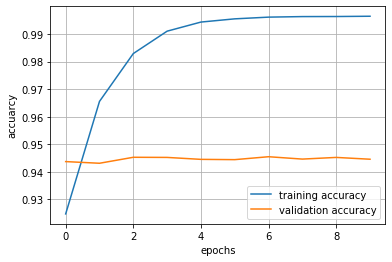

In [31]:
tr_accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])